# **MOIRAI EXPERIMENT: AQI-LA (Environmental)**

## **Libraries & Setup**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from statsmodels.tsa.seasonal import STL

### **Setup Device and Output**

In [4]:
CURRENT_DIR = os.getcwd()
PROJECT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, '..'))
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

In [5]:
from src.dataloader import load_data, get_splits
from src.baselines import BaselineModels
from src.moirai_wrapper import MoiraiPredictor
from src.evaluation import *
from src.plotting import *

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {DEVICE}")

Device using: cuda


In [7]:
OUTPUTS_DIR = f"../outputs"
os.makedirs(OUTPUTS_DIR, exist_ok=True)
if os.path.isdir(OUTPUTS_DIR):
    print(f"Detected output folder: {OUTPUTS_DIR}")
else:
    print(f"Cannot detect output folder")

Detected output folder: ../outputs


### **Load Config**

In [8]:
CONFIGS_DIR = f"../configs/config.yaml"
with open(CONFIGS_DIR, "r") as f:
    config = yaml.safe_load(f)

In [9]:
_, AQI_DATASET = config['datasets']
print(f"Detected dataset: {AQI_DATASET}")

Detected dataset: AQI_LA


### **Configurations for the Model**

In [10]:
MOIRAI_SMALL = config['models']['moirai_small']
MOIRAI_BASE = config['models']['moirai_base']

In [11]:
HORIZON = config['experiment']['horizon']
CTX_ZERO_SHOT = config['experiment']['context_length']['zero_shot']
CTX_FEW_SHOT = config['experiment']['context_length']['few_shot']
SEASONALITY = config['datasets'][AQI_DATASET]['seasonality']
FREQ = config['datasets'][AQI_DATASET].get('frequency', 'B')

In [12]:
print(f"Dataset: {AQI_DATASET}")
print(f"Horizon: {HORIZON}")
print(f"Zero-Shot Context: {CTX_ZERO_SHOT}")
print(f"Few-Shot Context: {CTX_FEW_SHOT}")

Dataset: AQI_LA
Horizon: 60
Zero-Shot Context: 60
Few-Shot Context: 240


## **Load Data**

In [13]:
df = load_data(AQI_DATASET, config)
display(df.head())
df.info()

,values
date,
2022-08-10,277
2022-08-11,155
2022-08-12,291
2022-08-13,291
2022-08-14,290


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 875 entries, 2022-08-10 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   values  875 non-null    int64
dtypes: int64(1)
memory usage: 13.7 KB


In [14]:
train, valid, test = get_splits(df, config)

Splits created:
- train: 215
- valid: 600
-  test: 60



## **Seasonality Check**

In [15]:
stl = STL(train['values'], period=SEASONALITY)
res = stl.fit()

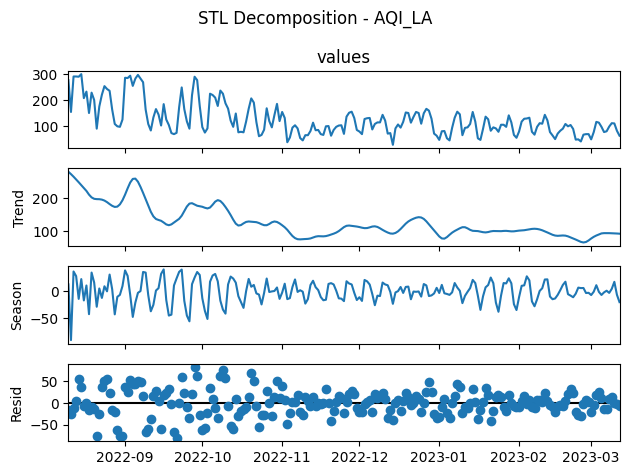

In [37]:
fig = res.plot()
plt.suptitle(f"STL Decomposition - {AQI_DATASET}")
plt.tight_layout()
plt.savefig(f"{OUTPUTS_DIR}/00_aqi_stl.png")
plt.show()

## **Model Initialization (Zero-Shot & Few-Shot)**

In [17]:
baselines = BaselineModels(
    seasonal_period=SEASONALITY,
    horizon=HORIZON)

In [18]:
moirai_models = {
    'Moirai-Small (ZS)': MoiraiPredictor(
        model_name=MOIRAI_SMALL,
        context_length=CTX_ZERO_SHOT,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ),
    
    'Moirai-Base (ZS)': MoiraiPredictor(
        model_name=MOIRAI_BASE,
        context_length=CTX_ZERO_SHOT,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ),
        
    'Moirai-Small (FewS)': MoiraiPredictor(
        model_name=MOIRAI_SMALL,
        context_length=CTX_FEW_SHOT, 
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ),
    
    'Moirai-Base (FewS)': MoiraiPredictor(
        model_name=MOIRAI_BASE,
        context_length=CTX_FEW_SHOT,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ)
}

In [19]:
print(f"Initialized {len(moirai_models)} Moirai variants.")

Initialized 4 Moirai variants.


In [20]:
valid_results, preds = rolling_cv(
    dataset_name=AQI_DATASET,
    train_series=train['values'],
    valid_series=valid['values'],
    baselines=baselines,
    moirai_models=moirai_models,
    config=config
)

[FOLD 1]: Predict 2023-01-12 to 2023-03-12
[FOLD 2]: Predict 2023-03-13 to 2023-05-11
[FOLD 3]: Predict 2023-05-12 to 2023-07-10
[FOLD 4]: Predict 2023-07-11 to 2023-09-08
[FOLD 5]: Predict 2023-09-09 to 2023-11-07
[FOLD 6]: Predict 2023-11-08 to 2024-01-06
[FOLD 7]: Predict 2024-01-07 to 2024-03-06
[FOLD 8]: Predict 2024-03-07 to 2024-05-05
[FOLD 9]: Predict 2024-05-06 to 2024-07-04
[FOLD 10]: Predict 2024-07-05 to 2024-09-02


## **Statisticals & Performance Analysis**

In [21]:
print("[MAE]")
mae_df = valid_results.groupby('model')['MAE'].mean().sort_values()
print(mae_df)

[MAE]
model
Moirai-Base (FewS)     23.281358
Moirai-Small (FewS)    24.950012
Moirai-Base (ZS)       29.922820
S-Naive                31.098333
Moirai-Small (ZS)      31.149334
ETS                    40.280895
Name: MAE, dtype: float64


In [22]:
print("[RMSE]")
rmse_df = valid_results.groupby('model')['RMSE'].mean().sort_values()
print(rmse_df)

[RMSE]
model
Moirai-Base (FewS)     30.955963
Moirai-Small (FewS)    33.644153
Moirai-Base (ZS)       37.245298
Moirai-Small (ZS)      39.349571
S-Naive                41.533624
ETS                    49.504027
Name: RMSE, dtype: float64


In [23]:
print(f"[MASE]")
mase_df = valid_results.groupby('model')['MASE'].mean().sort_values()
print(mase_df)

[MASE]
model
Moirai-Base (FewS)     0.465721
Moirai-Small (FewS)    0.495802
Moirai-Base (ZS)       0.597658
Moirai-Small (ZS)      0.609839
S-Naive                0.628187
ETS                    0.808269
Name: MASE, dtype: float64


In [24]:
best_bl, best_moirai, p_val = statistical_test(valid_results)
print(f"Wilcoxon Significance Test:")
print(f"Comparing Best Baseline ({best_bl}) vs Best Moirai ({best_moirai})")
print(f"p-value: {p_val:.4f} {'(Significant)' if p_val < 0.05 else '(Not Significant)'}")

Wilcoxon Significance Test:
Comparing Best Baseline (S-Naive) vs Best Moirai (Moirai-Base (FewS))
p-value: 0.0020 (Significant)


## **Visualization**

Plot saved: outputs\01_aqi_la_backtesting.png


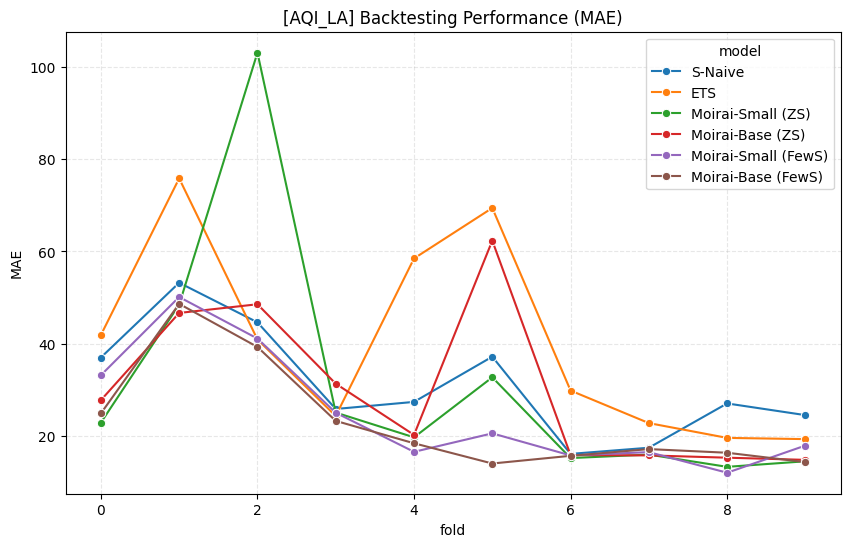

In [25]:
plot_backtesting_perf(valid_results, AQI_DATASET)

Plot saved: outputs\02_aqi_la_horizon_error.png


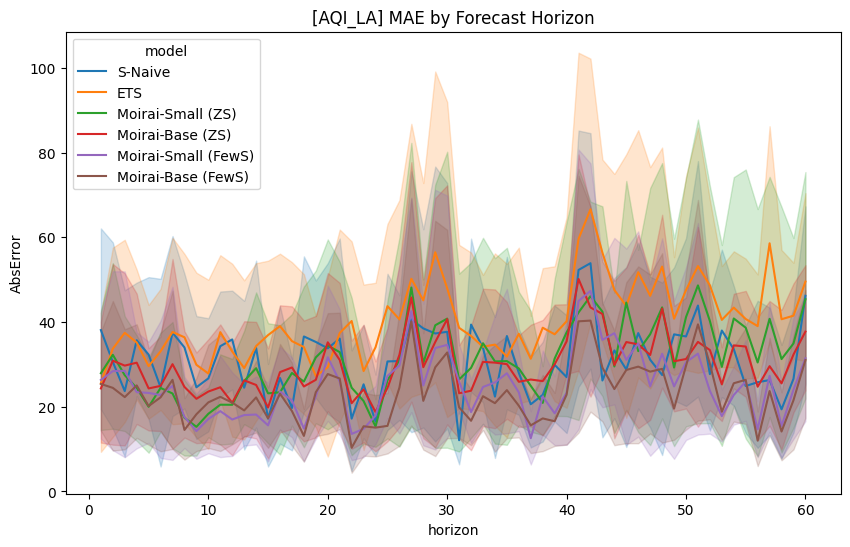

In [26]:
plot_error_by_horizon(preds, AQI_DATASET)

Plot saved: outputs\03_aqi_la_calibration.png


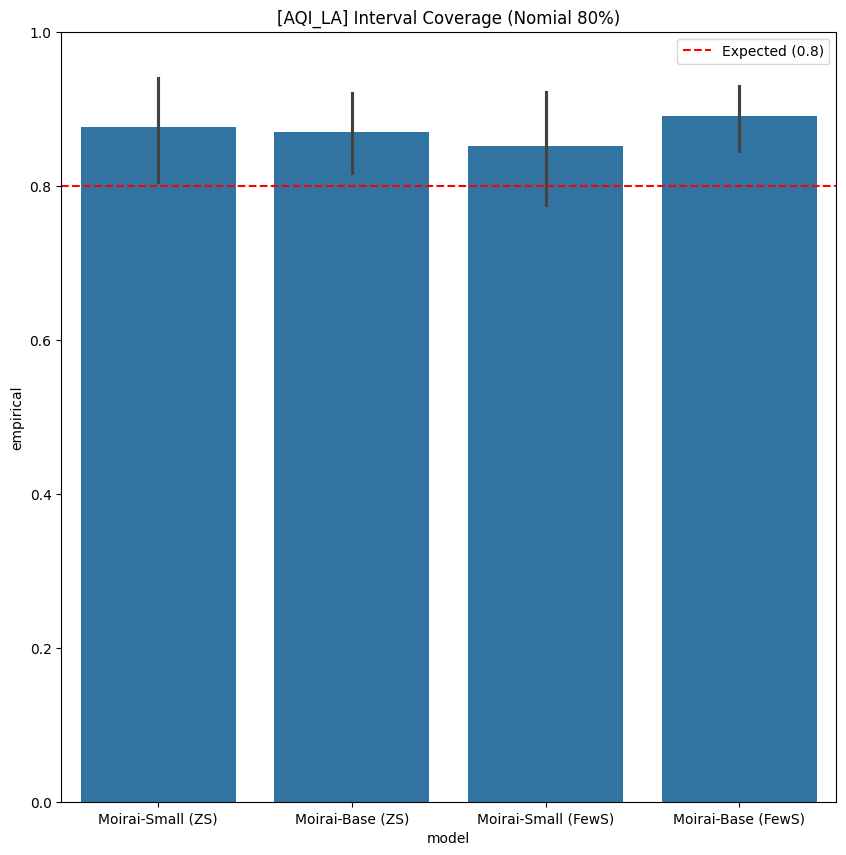

In [27]:
plot_calibration(preds, AQI_DATASET)

## **Final Inference**

In [28]:
full_history = pd.concat([train['values'], valid['values']])
final_preds = {}

In [29]:
for name, model in moirai_models.items():
    final_preds[name] = model.predict(full_history)

Plot forecast overlay saved: outputs\04_aqi_la_overlay_prediction.png


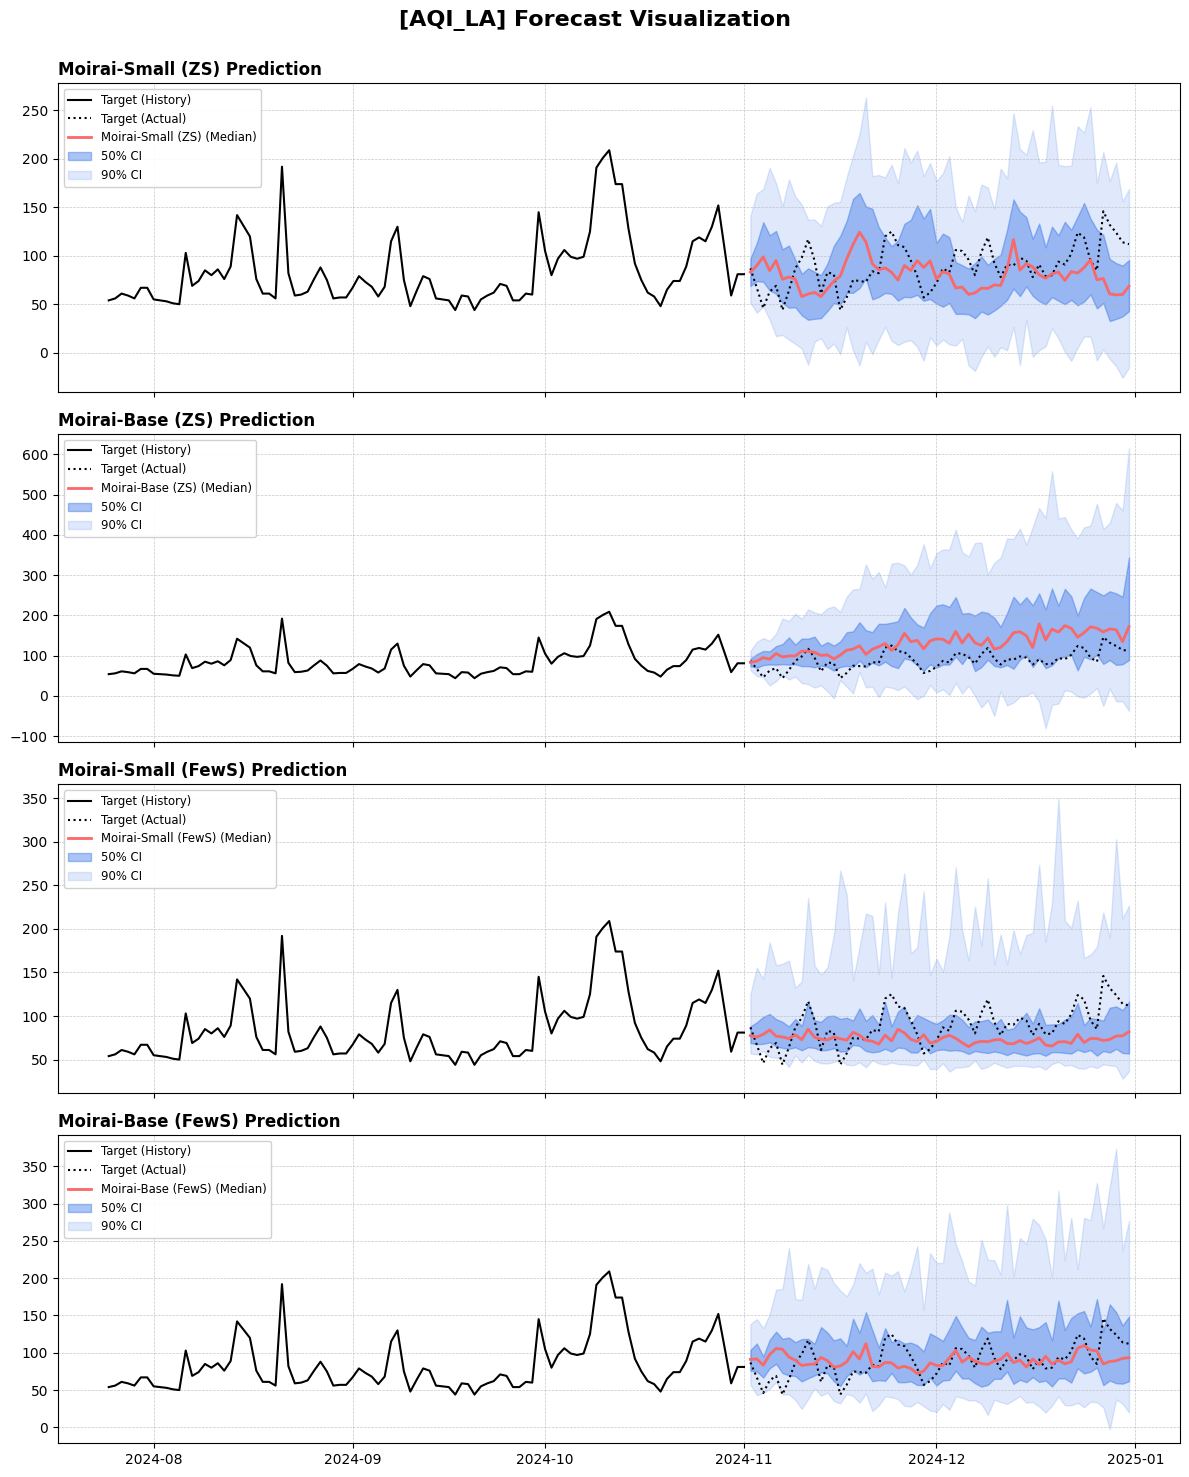

In [36]:
plot_forecast_overlay(full_history, test['values'], final_preds, f"{AQI_DATASET}")

In [31]:
y_true = test['values'].values
y_train_hist = full_history.values

In [32]:
baseline_preds = {
    'S-Naive': baselines.seasonal_naive(full_history),
    'ETS': baselines.ets(full_history)}

In [33]:
all_model_preds = final_preds.copy() 
all_model_preds.update(baseline_preds)

In [34]:
stats_list = []
for model_name, prediction in all_model_preds.items():
    if isinstance(prediction, dict):
        y_pred = prediction['median']
    else:
        y_pred = prediction
    metrics = cal_metrics(y_true, y_pred, y_train_hist, SEASONALITY)
    metrics['Pinball_0.5'] = pinball_loss(y_true, y_pred, 0.5)
    metrics['Model'] = model_name
    stats_list.append(metrics)

In [35]:
df_stats = pd.DataFrame(stats_list).set_index('Model')
print(f"[{AQI_DATASET}] Final Test Set Leaderboard:")
display(df_stats.sort_values(by='MAE'))

[AQI_LA] Final Test Set Leaderboard:


,MAE,RMSE,MASE,Pinball_0.5
Model,,,,
Moirai-Base (FewS),18.978123,23.839565,0.510497,9.489062
Moirai-Small (FewS),22.651661,27.388153,0.609313,11.325830
ETS,24.504060,30.146553,0.659141,12.252030
Moirai-Small (ZS),25.662273,31.689795,0.690296,12.831138
S-Naive,27.850000,36.281538,0.749144,13.925000
Moirai-Base (ZS),42.381630,47.707981,1.140035,21.190815


In [38]:

csv_path = os.path.join(OUTPUTS_DIR, f"{AQI_DATASET.lower()}_leaderboard.csv")
df_stats.sort_values(by="MAE").to_csv(csv_path)

print(f"Saved leaderboard to {csv_path}")

Saved leaderboard to ../outputs\aqi_la_leaderboard.csv
